# 1. Electricity Consumption Dataset Preparation

The dataset chosen for analysis is the Electricity Consumption dataset from Ireland, provided by the Commission for Energy Regulation (CER) as part of the CER Smart Metering initiative. This publicly available dataset captures electricity consumption and is updated twice an hour, resulting in 48 entries per day.

## Project Background

The dataset is sourced from the "Electricity Customer Behaviour Trial, 2009-2010, 1st Edition," archived by the Irish Social Science Data Archive in 2012. The data is publicly accessible at [this URL](https://www.ucd.ie/issda/data/commissionforenergyregulationcer/).

## Dataset Details

- **File Structure:** Six zipped files (File1.txt.zip to File6.txt.zip), each containing a single text file.
- **Data Format:** Each data file consists of three columns:
  1. Meter ID
  2. Five-digit code
  3. Day code (digits 1-3, with day 1 corresponding to January 1, 2009)
  4. Time code (digits 4-5, representing 30-minute intervals from 00:00:00 to 00:29:59)
  5. Electricity consumed during the 30-minute interval (in kWh)

### Unify Data :
This code aims to concatenate multiple text files into a single one. It defines a list called `files` containing the names of the files to be concatenated. The result of the concatenation will be saved in a new file named `FileData`.

In [ ]:
# List of input files to be concatenated
files = ['File1.txt', 'File2.txt', 'File3.txt', 'File4.txt', 'File5.txt', 'File6.txt']

# Output file where the concatenated data will be saved
output_file = 'FileData.txt'

# Function to concatenate files
def concatenate_files(input_files, output_file):
    # Open the output file in write mode
    with open(output_file, 'w') as output:
        # Iterate through each input file
        for file in input_files:
            # Open the current input file in read mode
            with open(file, 'r') as f:
                # Read the content of the input file
                content = f.read()
                # Write the content to the output file
                output.write(content)

# Call the function to concatenate files
concatenate_files(files, output_file)

print('Files concatenated into', output_file)

In [34]:
# Show the output file content
with open('FileData.txt', 'r') as f:
    header_lines = [next(f) for _ in range(10)]
    header_preview = ''.join(header_lines)
    print(f'Preview of FileData.txt:\n{header_preview}')

Preview of FileData.txt:
1392 19503 0.14
1392 19504 0.138
1392 19505 0.14
1392 19506 0.145
1392 19507 0.145
1392 19501 0.157
1392 19502 0.144
1392 19724 0.128
1392 19725 0.142
1392 19726 0.145



### Clean Data :

The purpose of this code is to clean and process hourly household electricity consumption data. Each observation has 24 values corresponding to the 24-hour consumption of a consumer for a day.

In [35]:
# Import the required libraries
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Input and output files
input_file = 'FileData.txt'
output_file_raw = 'raw_data.csv'
output_file = 'final_data.csv'

# Dictionary to store the data
data = {}

# Read the input file and store the lines
with open(input_file, 'r') as file:
    lines = file.readlines()

# Process each line in the input file
for line in lines:
    # Split the line into three parts: ID, date, and consumption
    ID, date, consumption = line.split()

    # Extract day and hour information from the date
    day = int(date[:3])
    half_hour = int(date[3:5])
    hour = (half_hour - 1) // 2
    
    # Initialize the data dictionary if necessary
    if ID not in data:
        data[ID] = {}
    
    if day not in data[ID]:
        data[ID][day] = [0.0] * 24

    # Update the consumption information
    if 0 <= hour <= 23:
        data[ID][day][hour] += float(consumption) * 1000  # Convert kWh to Wh
         

In [4]:
# Write the data to a CSV file
with open(output_file_raw, 'w', newline='') as file:
    writer = csv.writer(file)

    # Header
    writer.writerow(['ID', 'Day', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23'])
    
    # Write each row to the CSV file
    for ID, date_and_consumption in data.items():
        for day, consumption_list in date_and_consumption.items():
            # Join to combine the first two columns with spaces and the rest with commas
            row = [ID, day] + consumption_list
            writer.writerow(row)
            

Visualize all dataset before cleaning restrictions.

Number of unique users: 6435
Number of unique days: 536
Number of rows: 3291258


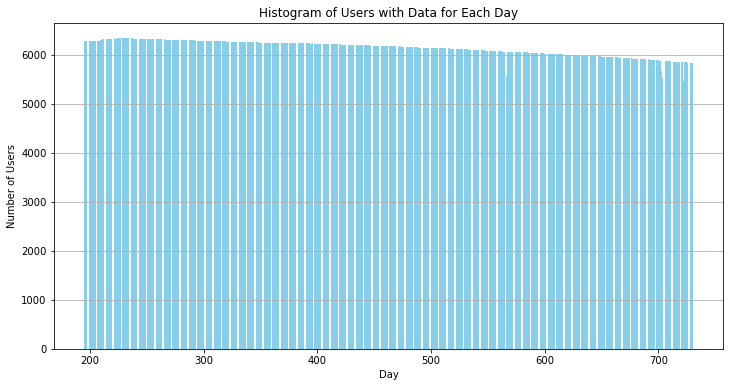

In [38]:
raw_data_df = pd.read_csv('raw_data.csv', delimiter=',', index_col=0)

print('Number of unique users:', len(raw_data_df.groupby('ID')))  # 6435
print('Number of unique days:', len(raw_data_df.groupby('Day')))  # 536
print('Number of rows:', len(raw_data_df))  # 3291258

# Group by day and count the number of users with data each day
daily_user_counts = raw_data_df.groupby('Day').size()

# Plot a histogram
plt.figure(figsize=(12, 6))
plt.bar(daily_user_counts.index, daily_user_counts, color='skyblue')
plt.title('Histogram of Users with Data for Each Day')
plt.xlabel('Day')
plt.ylabel('Number of Users')
plt.grid(axis='y')
plt.show()


The data preparation involves applying several filters suggested:

- All daily consumption associated with non-household consumers, defined as those with electricity consumption greater than 15 kWh at any hour of any day, has been removed.
- Observations where the consumption of any hour is missing have been removed.
- Observations with total daily consumption less than 100 W have been removed.

In [7]:
low_threshold = 100
high_threshold = 15000

# Identify IDs with daily consumption below the minimum threshold
IDs_below_threshold = {
    ID for ID, date_and_consumption in data.items()
    if any(sum(consumption_list) < low_threshold for day, consumption_list in date_and_consumption.items())
}

# Count the total number of days meeting the condition
total_days_below_threshold = sum(
    sum(sum(consumption_list) < low_threshold for day, consumption_list in date_and_consumption.items())
    for ID, date_and_consumption in data.items()
)

# Identify IDs with maximum consumption exceeding 15000 Wh in any hour
IDs_above_threshold = {
    ID for ID, date_and_consumption in data.items()
    if any(max(consumption_list) > high_threshold for day, consumption_list in date_and_consumption.items())
}

# Create a dictionary to store the cleaned data with all the filters applied
cleaned_data = {
    ID: {
        day: consumption_list
        for day, consumption_list in date_and_consumption.items()
        if all(hour_consumption != 0 for hour_consumption in consumption_list) and sum(consumption_list) > low_threshold
    }
    for ID, date_and_consumption in data.items()
    if ID not in IDs_above_threshold
}

# Create the CSV file
with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file)
    # Header
    writer.writerow(['ID', 'Day', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23'])
    
    # Write each row to the CSV file
    for ID, date_and_consumption in cleaned_data.items():
        for day, consumption_list in date_and_consumption.items():
            # Join to combine the first two columns with spaces and the rest with commas
            row = [ID, day] + consumption_list
            writer.writerow(row)

In [40]:
# Show the first few lines of the CSV file
final_data_df = pd.read_csv('final_data.csv', delimiter=',', index_col=0)
final_data_df.head(10)

,Day,H0,H1,H2,H3,H4,H5,H6,H7,H8,...,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
ID,,,,,,,,,,,,,,,,,,,,,
1392,195,301.0,278.0,285.0,289.0,283.0,292.0,281.0,2093.0,270.0,...,275.0,299.0,325.0,503.0,815.0,493.0,489.0,327.0,276.0,277.0
1392,197,455.0,299.0,296.0,282.0,275.0,284.0,283.0,305.0,289.0,...,260.0,295.0,262.0,423.0,602.0,519.0,808.0,443.0,474.0,366.0
1392,198,275.0,276.0,297.0,291.0,274.0,272.0,274.0,294.0,280.0,...,296.0,280.0,440.0,754.0,928.0,710.0,508.0,470.0,450.0,426.0
1392,199,306.0,290.0,289.0,286.0,281.0,311.0,274.0,273.0,297.0,...,1474.0,2785.0,2822.0,3079.0,2500.0,950.0,697.0,440.0,2725.0,620.0
1392,200,303.0,299.0,478.0,1154.0,306.0,282.0,275.0,270.0,302.0,...,797.0,402.0,283.0,343.0,1304.0,2972.0,734.0,447.0,3933.0,776.0
1392,196,275.0,276.0,272.0,283.0,289.0,279.0,268.0,304.0,265.0,...,290.0,287.0,284.0,397.0,343.0,339.0,1048.0,2391.0,412.0,296.0
1392,202,365.0,291.0,304.0,274.0,281.0,301.0,268.0,652.0,290.0,...,259.0,290.0,269.0,429.0,461.0,447.0,924.0,1214.0,686.0,435.0
1392,201,511.0,379.0,289.0,269.0,304.0,268.0,285.0,299.0,282.0,...,266.0,287.0,255.0,292.0,256.0,289.0,269.0,535.0,737.0,579.0
1392,204,395.0,293.0,315.0,310.0,266.0,309.0,268.0,280.0,1635.0,...,500.0,535.0,530.0,591.0,539.0,1755.0,623.0,546.0,862.0,550.0


Now we visualize the number of users for each day when we have data.

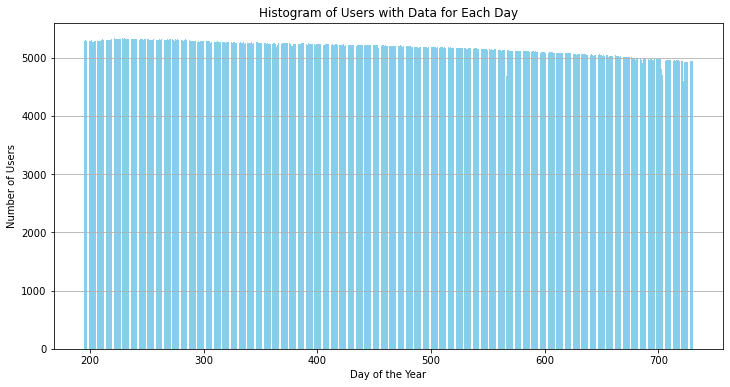

In [41]:
# Group by day and count the number of users with data each day
daily_user_counts = final_data_df.groupby('Day').size()

# Plot a histogram
plt.figure(figsize=(12, 6))
plt.bar(daily_user_counts.index, daily_user_counts, color='skyblue')
plt.title('Histogram of Users with Data for Each Day')
plt.xlabel('Day of the Year')
plt.ylabel('Number of Users')
plt.grid(axis='y')
plt.show()

The following code snippet prints various statistics related to the processed electricity consumption data. It provides insights into the distribution of users based on daily consumption and the duration of data available for each user.

In [10]:
print('Number of unique users:', len(final_data_df.groupby('ID')))  # 5483
print('Number of unique days:', len(final_data_df.groupby('Day')))  # 536
print('Number of rows:', len(final_data_df))  # 2772102

print('Number of users with more than 365 days of data:', (final_data_df.groupby('ID')['Day'].nunique() > 365).sum())  # 5118
print('Number of users with 365 days or fewer of data:', (final_data_df.groupby('ID')['Day'].nunique() <= 365).sum())  # 365

print('Number of users with daily consumption below 100 Wh:', len(IDs_below_threshold))  # 220
print('Total number of days with daily consumption below 100 Wh:', total_days_below_threshold)  # 15729
print('Number of users with maximum consumption above 15000 Wh:', len(IDs_above_threshold))  # 946


Number of unique users: 5483
Number of unique days: 536
Number of rows: 2772102
Number of users with more than 365 days of data: 5118
Number of users with 365 days or fewer of data: 365
Number of users with daily consumption below 100 Wh: 220
Total number of days with daily consumption below 100 Wh: 15729
Number of users with maximum consumption above 15000 Wh: 946


## Ireland Centroids Dataset Introduction

In addition to the cleaned electricity consumption data, this analysis incorporates information from the `ireland_centroids.csv` file. This file contains data related to 21 clusters, each representing specific patterns of electricity consumption throughout the day. The structure of the dataset consists of 21 rows, each corresponding to a cluster, and 24 columns, representing consumption values for each hour.

In [43]:
# Show the first few lines of the CSV file
centroids_data_df = pd.read_csv('ireland_centroids.csv', delimiter=';', index_col=0)
# Change decimal format of consumption columns
centroids_data_df = centroids_data_df.replace(',', '.', regex=True).astype(float)

centroids_data_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,666.404799,484.334812,403.495851,370.524245,363.995688,391.122558,496.106402,659.053309,732.292615,661.010030,...,623.648993,647.050029,688.732620,989.968102,1397.614702,1526.123454,1467.507396,1424.304946,1277.736255,1007.610938
1,7988.886395,7268.747308,6804.774458,6640.175034,6434.407857,6337.863037,6328.513272,6650.202032,7212.943425,7726.617321,...,9000.765661,8950.589565,9127.546640,9296.297133,9482.043076,9707.379190,9684.543000,9512.932352,8907.892765,8432.035796
2,5063.535694,4365.207050,3896.869676,3597.825253,3459.254087,3456.880073,3567.784944,3849.556655,4187.166463,4334.573001,...,4875.544757,5077.234460,5581.563883,6209.943400,6724.074224,7015.644223,7026.273768,6932.770822,6616.379795,5979.589681
3,664.649717,484.243384,403.549855,369.608868,362.380053,393.048123,495.551953,690.898946,841.492934,824.325715,...,901.497478,1392.202893,2653.601995,2977.457630,1610.714750,1378.719383,1351.973793,1336.130244,1202.788110,964.678797
4,8317.068925,8494.768477,8141.301943,7593.319714,6861.971765,6048.787909,5365.844544,4482.354592,2397.455240,2033.887394,...,2013.833416,1976.317721,1890.804684,1553.519349,1301.882910,1304.583790,1332.658196,1404.319548,1763.127720,5746.453081
5,320.961780,255.852941,229.072780,219.640032,219.840974,230.343019,278.940345,365.180981,400.590317,395.799201,...,339.481362,350.846844,383.455302,445.239048,459.056025,460.794118,481.062360,508.571786,488.214057,411.432171
6,744.034096,531.728164,450.161884,419.390594,413.726915,434.354907,511.508301,770.966877,2036.330275,4275.530081,...,1008.030692,1040.889799,1179.394642,1439.467895,1541.921779,1564.426767,1509.727349,1470.473534,1314.840560,1037.554792
7,1601.166038,1170.655912,959.144399,878.835433,843.334212,861.245520,1003.845919,1423.542890,2003.284886,2671.094546,...,4619.613355,4631.944016,4846.799617,5423.645287,5400.697082,4917.796205,4308.656827,3766.674000,3124.949010,2392.107585
8,3143.240185,2796.657691,2539.800582,2408.069459,2377.959000,2403.000597,2524.842335,2824.192953,2941.967984,2819.099060,...,2571.329222,2558.569303,2656.323198,2854.969178,2976.304606,2999.867704,3070.490860,3190.848411,3166.725462,3052.212142
9,924.008743,661.893347,548.395662,500.160106,487.616035,507.346214,590.925469,818.703127,1197.057764,1920.451723,...,1424.847904,1408.849581,1557.612016,1876.667265,1996.534092,2021.527372,1928.341796,1826.092761,1607.998004,1261.050153


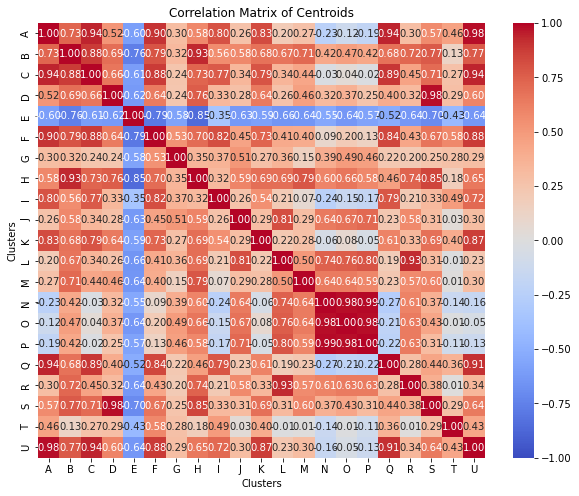

In [44]:
# Transpose the DataFrame
centroids_data_df_T = centroids_data_df.T

# Calculate the correlation matrix
correlation_matrix = centroids_data_df_T.corr()

# Rename index and columns with cluster names (letters A to U)
correlation_matrix.index = list("ABCDEFGHIJKLMNOPQRSTU")
correlation_matrix.columns = list("ABCDEFGHIJKLMNOPQRSTU")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Centroids')
plt.xlabel('Clusters')
plt.ylabel('Clusters')
plt.show()

### Assigning Centroids to Daily Consumption Profiles:

In this step, the code utilizes two datasets: `FinalData.csv`, which contains daily electricity consumption data for each user, and `ireland_centroids.csv`, representing 21 consumption patterns through centroids. The objective is to assign a centroid label to each daily consumption profile based on the closest match.

This code iteratively calculates the Euclidean distance between each daily consumption profile and the 21 centroids, assigning the closest centroid label to each row. The resulting dataset, `FinalData+Cluster.csv`, facilitates further analysis of electricity consumption patterns based on identified clusters.


### We could discard this code below and use only: ID, Day, Centroid

In [119]:
# Add a column for the associated centroid to each consumption row
final_data_df['Centroid'] = np.nan

# Iterate through each row in the consumption dataset
for i in range(len(final_data_df)):
    # Extract hourly consumption values from the row. row[1:-1] excludes the first and last columns: 'Day' and 'Centroid'
    consumption_array = np.array(final_data_df.iloc[i, 1:-1], dtype=float) # [hour_1, hour_2, ..., hour_24]

    # Calculate the Euclidean distance to each centroid
    distances = np.linalg.norm(centroids_data_df.values - consumption_array, axis=1)
    # distances = [distance_centroid_1, distance_centroid_2, ..., distance_centroid_21]
    
    # Assign the centroid with the lowest distance as letters A, B, C, ..., U
    final_data_df.iloc[i, -1] = chr(65 + int(np.argmin(distances)))

# Save the updated dataset with assigned centroids
final_data_df.to_csv('final_data_cluster_all.csv', index=True)


In [127]:
# Add a column for the associated centroid to each consumption row
final_data_centroid_df = final_data_df[['Day']].copy()
final_data_centroid_df['Centroid'] = np.nan

# Change decimal format of consumption columns
centroids_data_df = centroids_data_df.replace(',', '.', regex=True).astype(float)

# Iterate through each row in the consumption dataset
for i in range(len(final_data_df)):
    # Extract hourly consumption values from the row. row[1:-1] excludes the first and last columns: 'Day' and 'Centroid'
    consumption_array = np.array(final_data_df.iloc[i, 1:-1], dtype=float) # [hour_1, hour_2, ..., hour_24]

    # Calculate the Euclidean distance to each centroid
    distances = np.linalg.norm(centroids_data_df.values - consumption_array, axis=1)
    # distances = [distance_centroid_1, distance_centroid_2, ..., distance_centroid_21]

    # Assign the centroid with the lowest distance as letters A, B, C, ..., U
    final_data_centroid_df.iloc[i, -1] = chr(65 + int(np.argmin(distances)))

# Save the updated dataset with assigned centroids
final_data_centroid_df.to_csv('final_data_cluster.csv', index=True)

In [7]:
# Show the first few lines of the CSV file
final_data_cluster_df = pd.read_csv('final_data_cluster.csv', delimiter=',')
final_data_cluster_df.head(10)

,ID,Day,Centroid
0,1392,195,F
1,1392,197,F
2,1392,198,F
3,1392,199,D
4,1392,200,A
5,1392,196,F
6,1392,202,F
7,1392,201,F
8,1392,204,F
9,1392,203,F


The following code snippet calculates and prints various statistics based on the processed electricity consumption data. The focus is on understanding the frequency of each centroid for individual users and the distribution of users according to their assigned daily consumption centroids.

In [79]:
#########   Count of centroids in sorted order      #########

# Count the occurrences of each centroid
centroid_count_ord = final_data_cluster_df['Centroid'].value_counts().sort_index()

print("Count of occurrences for each centroid:")
print(centroid_count_ord.to_string())

# Save to a CSV with the ordered centroid count
centroid_count_ord.to_csv('centroid_count.csv')

Count of occurrences for each centroid:
A    524708
B       583
C      6012
D    224530
E      2818
F    748779
G     85323
H     26110
I     28735
J     78610
K    155179
L    262283
M    122324
N      5467
O      3529
P     27301
Q    168034
R     77462
S     89427
T     85133
U     49755


In [83]:
#########   Count of centroids in descending order  #########

# Count the number of occurrences for each centroid
centroid_count_desc = final_data_cluster_df['Centroid'].value_counts()

print("Count of occurrences for each centroid in descending order:")
print(centroid_count_desc.to_string())

# Save to a CSV with the ordered centroid count
centroid_count_desc.to_csv('centroid_count_desc.csv')

Count of occurrences for each centroid in descending order:
F    748779
A    524708
L    262283
D    224530
Q    168034
K    155179
M    122324
S     89427
G     85323
T     85133
J     78610
R     77462
U     49755
I     28735
P     27301
H     26110
C      6012
N      5467
O      3529
E      2818
B       583


In [65]:
#########   Distribution of centroids for each user   #########

# Create a new DataFrame grouped by ID and Centroid
grouped_by_user_centroid = final_data_cluster_df.groupby(['ID', 'Centroid']).size().reset_index(name='Count')

# Use pivot_table to obtain the desired table
user_centroid_table = grouped_by_user_centroid.pivot_table(index='ID', columns='Centroid', values='Count', fill_value=0)

# Save to a CSV with the distribution of centroids.
user_centroid_table.to_csv('centroid_distribution.csv')

# Show the first few lines of the CSV file
user_centroid_table.head(10)

Centroid,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,T,U
ID,,,,,,,,,,,,,,,,,,,,,
1000,128,0,0,14,0,360,5,0,0,0,...,20,2,0,0,0,0,0,0,3,0
1001,0,0,0,0,0,477,0,0,32,0,...,24,1,0,0,0,0,0,0,2,0
1002,39,0,0,0,0,440,27,0,0,1,...,19,1,0,0,0,2,0,0,4,0
1003,144,0,0,83,0,1,10,1,0,11,...,48,21,0,0,1,45,16,15,30,0
1004,6,0,0,7,0,5,1,14,7,18,...,5,22,0,0,1,117,27,70,1,183
1005,127,0,0,26,0,24,29,8,7,29,...,40,26,0,0,1,36,19,20,79,14
1006,142,0,0,102,0,92,1,3,0,0,...,17,9,0,0,0,39,1,20,0,24
1007,37,0,1,24,1,0,20,3,1,28,...,19,33,0,0,3,48,33,36,152,11
1008,91,0,0,88,0,6,14,5,21,17,...,55,40,0,0,3,36,17,41,28,6


### Filter Users by Centroid Distribution:

The following code snippet filters users based on a specified threshold for the number of different clusters assigned to them. The code reads a CSV file containing the distribution of centroids for each user and selects users with a count of unique clusters below the specified threshold.

In [5]:
# Specify the threshold for the minimum number of different clusters (above 20)
minimum_clusters = 6
threshold_clusters = 10

In [74]:
# Load the CSV file into a DataFrame
centroid_distribution_df = pd.read_csv('centroid_distribution.csv')

# Filter IDs with a higher number of different clusters than the minimum and lower number of different clusters than the threshold
filtered_rows = []
for index, row in centroid_distribution_df.iterrows():
    clusters = row[1:]  # [f(0), ..., f(20)]
    clusters_cleaned = [c for c in clusters if c != 0]  # Remove unused clusters

    different_clusters_count = len(clusters_cleaned)
    
    if different_clusters_count >= minimum_clusters and different_clusters_count <= threshold_clusters:
        filtered_rows.append(row)
        
# Create a DataFrame with the filtered results
filtered_df = pd.DataFrame(filtered_rows)

filtered_df['ID'] = filtered_df['ID'].astype(int)

# Generate a CSV with the filtered results
filtered_df.to_csv(f'filtered{minimum_clusters}-{threshold_clusters}_users_centroids.csv', index=False)

# Calculate and display the number of IDs in the DataFrame
print(f"Number of IDs in the DataFrame generated: {len(filtered_df)}")

# Show the first few lines of the CSV file
print(filtered_df.head(10).to_string(index=False))

Number of IDs in the DataFrame generated: 1024
  ID   A  B  C   D  E   F  G  H  I  J  K   L  M  N  O  P  Q  R  S  T  U
1000 128  0  0  14  0 360  5  0  0  0  4  20  2  0  0  0  0  0  0  3  0
1002  39  0  0   0  0 440 27  0  0  1  1  19  1  0  0  0  2  0  0  4  0
1013 129  0  0  20  0 349  3  0  0  0  6  23  5  0  0  0  1  0  0  0  0
1017  55  0  0 198  0 122  1  0  0  5 22 125  3  0  0  0  0  1  0  1  0
1022 120  0  0 177  0 105 64  0  0  1  4  49  8  0  0  0  1  0  0  6  0
1025 159  0  0  13  0 335  1  0  0  0  5  16  1  0  0  0  2  0  0  0  0
1027   8  0  0  26  0 407  4  0  0  2  1  79  8  0  0  0  0  0  0  0  0
1037  29  0  0   2  0 486  2  0  0  1  0  14  0  0  0  0  0  0  0  0  0
1040   0  0  0   1  0   0  6  0  0  5  0   2  4  0  0  0  0  2  3  0  0
1041  47  0  0  14  0 438  0  0  0  0  2  22  3  0  0  0  1  0  0  0  0


### Extract Consecutive Consumption Patterns
This section of code extracts consecutive consumption patterns from the dataset. Here's a breakdown of the process:

- **Find Common First and Last Days**: It identifies the most common first and last days across all IDs in the distribution data. These days respectively, can be used as orientation to decide the number of consecutive days required for analysis.

- **Extract Consecutive Clusters**: For each user, the code extracts consecutive consumption clusters over the specified number of days, starting from the most common first day.

This process facilitates the identification of consumption patterns over a specified consecutive period, offering insights into users' long-term consumption behaviors. These extracted consumption patterns serve as the dataset for developing predictive models and gaining deeper understanding of consumption trends.

In [24]:
# Read the distribution data from a CSV file with a specific naming convention
df_distribution = pd.read_csv(f'filtered{minimum_clusters}-{threshold_clusters}_users_centroids.csv')

# Find the most common first day across all IDs in df_distribution. We will use this as a starting point.
first_days_distribution = final_data_cluster_df[final_data_cluster_df['ID'].isin(df_distribution['ID'])].groupby('ID')['Day'].min().value_counts()
most_common_first_day_distribution = first_days_distribution.idxmax()

print('Most common first day:', most_common_first_day_distribution) # 195

##### Find the most common last day across all IDs in df_distribution. We will use this as a ending point.
last_days_distribution = final_data_cluster_df[final_data_cluster_df['ID'].isin(df_distribution['ID'])].groupby('ID')['Day'].max().value_counts()
most_common_last_day_distribution = last_days_distribution.idxmax()

print('Most common last day:', most_common_last_day_distribution) # 730

print('Number of days between the most common first and last days:', most_common_last_day_distribution - most_common_first_day_distribution + 1) # 536

Most common first day: 195
Most common last day: 730
Number of days between the most common first and last days: 536


Veamos qué longitud nos interesa para nuestros modelos

In [ ]:
ids_with_sequences = []
start_day_sequences = 90
end_day_current_sequence = most_common_last_day_distribution - most_common_first_day_distribution + 2

# Iterate over each possible consecutive sequence length
for num_consecutive_days in range(start_day_sequences, end_day_current_sequence):
    # Initialize counter for number of IDs with sequences of current length
    num_ids = 0
    
    # Iterate over each row in the distribution dataframe
    for index, row in df_distribution.iterrows():
        id_household = int(row['ID'])  # Save the ID of the current household

        # DataFrame containing rows from final_data_cluster_df corresponding to the current household
        df_id = final_data_cluster_df[final_data_cluster_df['ID'] == id_household]

        # Sort by date to ensure chronological order
        df_id = df_id.sort_values(by='Day')

        # Initialize variables to store the previous day, a counter, and a list of clusters
        previous_day = None
        consecutive_days = 0

        # Iterate over each row in the dataframe for the current household
        for idx, r in df_id.iterrows():
            current_day = r['Day']  # Save the current day

            # Check if the current day is consecutive to the previous day
            if previous_day is not None and current_day == previous_day + 1:
                consecutive_days += 1

                # If the required consecutive days are achieved, increment the counter and exit the loop.
                if consecutive_days == num_consecutive_days:
                    num_ids += 1
                    break
            else:
                # First day of a new sequence
                if previous_day is not None:
                    consecutive_days = 0

            # Update the previous day
            previous_day = current_day
    
    # Store the number of IDs with sequences of current length
    ids_with_sequences.append(num_ids)

# Create a DataFrame with the number of IDs with sequences of different lengths
df_sequences = pd.DataFrame({'Consecutive Days': range(start_day_sequences, end_day_current_sequence), 'Number of IDs': ids_with_sequences})

# Save the DataFrame to a CSV file
df_sequences.to_csv('sequences_distribution.csv', index=False)


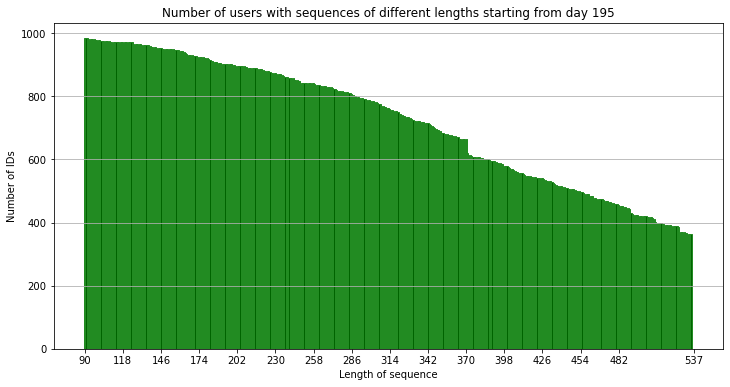

In [79]:
# Show the first few lines of the CSV file
df_sequences = pd.read_csv('sequences_distribution.csv')

# Calcular los valores intermedios para el eje X
middle_values = list(range(start_day_sequences + 28, end_day_current_sequence - 28, 28))
# Añadir el primer y el último elemento al principio y al final de la lista
xticks_values = [start_day_sequences] + middle_values + [end_day_current_sequence]

# Plot the histogram. Starting from day 250 to 450 length of sequence
plt.figure(figsize=(12, 6))
plt.bar(df_sequences['Consecutive Days'], df_sequences['Number of IDs'], color='darkgreen', edgecolor='forestgreen')
plt.title(f'Number of users with sequences of different lengths starting from day {most_common_first_day_distribution}')
plt.xlabel('Length of sequence')
plt.ylabel('Number of IDs')
plt.grid(axis='y')
plt.xticks(xticks_values, xticks_values)
plt.show()


Nos interesa ..

In [ ]:
# Minimum number of consecutive days required
num_consecutive_days = 400

In [ ]:
# List to store IDs with consecutive clusters
id_clusters_consecutive = []

# Iterate over each row in the distribution dataframe
for index, row in df_distribution.iterrows():
    id_household = int(row['ID'])  # Save the ID of the current household

    # DataFrame containing rows from final_data_cluster_df corresponding to the current household
    df_id = final_data_cluster_df[final_data_cluster_df['ID'] == id_household]
    
    # Sort by date to ensure chronological order
    df_id = df_id.sort_values(by='Day')
    
    # Initialize variables to store the previous day, a counter, and a list of clusters
    previous_day = None
    consecutive_days = 0
    cluster_list = []
    first_day = True

    # Iterate over each row in the dataframe for the current household
    for idx, r in df_id.iterrows():
        cluster_day = r['Centroid']  # Save the cluster of the current day
        current_day = r['Day']  # Save the current day

        # Check if the first day of the current sequence is different from the most common first day
        if first_day:
            if current_day != most_common_first_day_distribution:
                break
            first_day = False

        # Check if the current day is consecutive to the previous day
        if previous_day is not None and current_day == previous_day + 1:
            consecutive_days += 1
            cluster_list.append(cluster_day)
            
            # If the required consecutive days are achieved, add the ID and cluster list to the final list. Exit the loop.
            if consecutive_days == num_consecutive_days:
                end_day_current_sequence = current_day
                id_clusters_consecutive.append([id_household] + cluster_list)
                break
        else:
            # First day of a new sequence
            if previous_day is None:
                consecutive_days = 1
                cluster_list.append(cluster_day)

            # Reset counters and lists if days are not consecutive
            else:
                consecutive_days = 0
                cluster_list = []
                if current_day != previous_day + 1:
                    break
        
        # Update the previous day
        previous_day = current_day
        
# Create a dataframe from the list of IDs with consecutive clusters
df_sequence_pattern = pd.DataFrame(id_clusters_consecutive, columns=['ID'] + [f'ClusterDay{i+1}' for i in range(num_consecutive_days)])

# Write the dataframe to a CSV file
df_sequence_pattern.to_csv(f'sequence_patterns_2_{minimum_clusters}-{threshold_clusters}.csv', index=False)

In [78]:
print('Length of the sequence pattern dataframe:', len(df_sequence_pattern))  # 493
df_sequence_pattern.head(10)

Length of the sequence pattern dataframe: 493


,ID,ClusterDay1,ClusterDay2,ClusterDay3,ClusterDay4,ClusterDay5,ClusterDay6,ClusterDay7,ClusterDay8,ClusterDay9,...,ClusterDay391,ClusterDay392,ClusterDay393,ClusterDay394,ClusterDay395,ClusterDay396,ClusterDay397,ClusterDay398,ClusterDay399,ClusterDay400
0,1000,A,F,F,A,L,F,A,F,F,...,F,F,F,A,F,F,F,F,F,F
1,1013,A,A,F,F,F,F,F,F,F,...,F,F,F,F,F,A,F,F,F,F
2,1022,G,L,D,G,D,F,F,F,F,...,L,L,A,L,G,F,G,G,L,D
3,1037,F,F,F,F,F,F,F,F,F,...,F,A,F,F,F,F,F,F,F,F
4,1084,F,F,F,F,F,F,F,F,F,...,D,F,F,F,F,F,L,F,F,F
5,1086,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,F
6,1090,H,H,H,H,H,I,H,H,H,...,I,I,H,I,I,I,I,I,I,H
7,1093,F,F,F,F,F,F,F,F,F,...,A,A,F,F,A,F,F,A,F,F
8,1098,F,A,F,L,F,L,F,F,A,...,F,F,F,F,F,F,F,F,F,F
9,1101,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,F


## Exploring Data for Prediction Modeling

Before delving into the code, it's important to clarify the objective behind this data exploration. We aim to identify an appropriate ID from the dataset for further analysis with prediction models. Specifically, we are searching for a user without repetitive sequences. This choice is crucial for ensuring the effectiveness of our prediction models, as repetitive sequences may introduce biases and affect the generalization capabilities of the models.

With this objective in mind, we will proceed to analyze the dataset to identify a suitable ID that meets our criteria. The code provided below will assist us in this exploration by examining the cluster patterns associated with different IDs and selecting an appropriate candidate for prediction modeling.


In [45]:
# Ejemplo de uso:
# target_id = 1000
# target_id = 1022
target_id = 5121

Cluster counts for ID 1022:
Cluster A: 106
Cluster D: 117
Cluster F: 76
Cluster G: 55
Cluster K: 3
Cluster L: 30
Cluster M: 6
Cluster Q: 1
Cluster T: 6


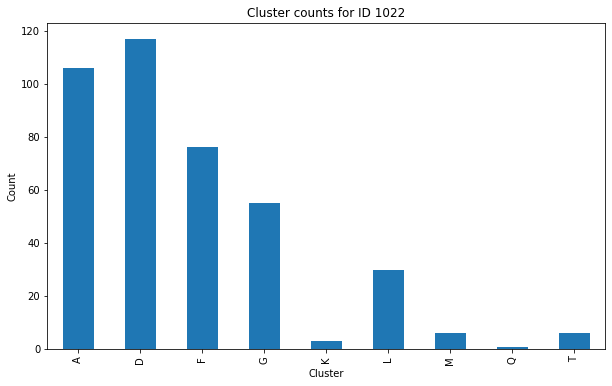

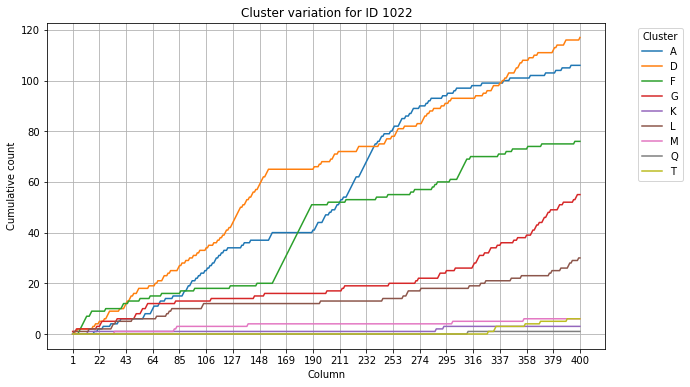

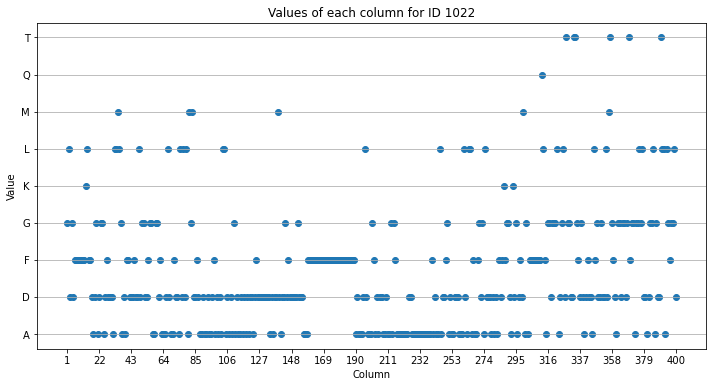

In [47]:
# Load the dataframe from the CSV file
df = pd.read_csv("sequence_patterns_2_6-10.csv")

def plot_cluster_counts_by_id(dataframe, id):
    # Filter the dataframe by the provided ID
    id_filtered_df = dataframe[dataframe['ID'] == id]
    
    # Select all columns representing clusters
    clusters = id_filtered_df.iloc[:, 1:]
    
    # Count occurrences of each cluster
    cluster_counts = clusters.apply(pd.value_counts).fillna(0)

    # Sum counts to get total occurrences of each cluster
    total_counts_per_cluster = cluster_counts.sum(axis=1)

    # Print the cluster counts
    print(f"Cluster counts for ID {id}:")
    for cluster, count in total_counts_per_cluster.items():
        print(f"Cluster {cluster}: {int(count)}")

    # Plot the cluster counts
    plt.figure(figsize=(10, 6))
    total_counts_per_cluster.plot(kind='bar')
    plt.title('Cluster counts for ID {}'.format(id))
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.show()

def plot_cluster_variation(dataframe, id):
    # Filter the dataframe by the provided ID
    id_filtered_df = dataframe[dataframe['ID'] == id]
    
    # Select all columns representing clusters
    clusters = id_filtered_df.iloc[:, 1:]
    
    # Count occurrences of each cluster in each column
    cluster_counts = clusters.apply(pd.value_counts).fillna(0)
    
    # Sum counts to get cumulative counts of each cluster in each column
    cumulative_counts_per_cluster = cluster_counts.cumsum(axis=1)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    for cluster in cumulative_counts_per_cluster.index:
        plt.plot(cumulative_counts_per_cluster.loc[cluster], label=cluster)
    
    plt.title('Cluster variation for ID {}'.format(id))
    plt.xlabel('Column')
    plt.ylabel('Cumulative count')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(range(0, len(cumulative_counts_per_cluster.columns), 21), range(1, len(cumulative_counts_per_cluster.columns) + 1, 21))
    plt.grid(True)
    plt.show()

def plot_consecutive_values(dataframe, id):
    # Filter the dataframe by the provided ID
    id_filtered_df = dataframe[dataframe['ID'] == id]
    
    # Get the columns representing clusters
    cluster_columns = id_filtered_df.columns[1:]
    
    # Get the rows corresponding to the given ID
    id_row = id_filtered_df.iloc[0, 1:]  # Exclude the first column (ID)
    
    # Get the unique letters present in the data for the given ID
    unique_letters = sorted(set(letter for letter in id_row if letter.strip()))  # Filter out empty letters and sort
    
    # Create a mapping from letters to their positions along the Y-axis
    letter_position_mapping = {letter: i for i, letter in enumerate(sorted(unique_letters))}
    
    # Convert letters in id_row to their corresponding positions
    id_row_positions = [letter_position_mapping[letter] for letter in id_row]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(cluster_columns)), id_row_positions)
    plt.title('Values of each column for ID {}'.format(id))
    plt.xlabel('Column')
    plt.ylabel('Value')
    plt.xticks(range(0, len(cluster_columns), 21), range(1, len(cluster_columns) + 1, 21))  # Jumps of 21 at a time
    plt.yticks(range(len(unique_letters)), sorted(unique_letters))  # Set the present letters on the Y axis in alphabetical order
    plt.grid(axis='y')
    plt.show()

plot_cluster_counts_by_id(df, target_id)
plot_cluster_variation(df, target_id)
plot_consecutive_values(df, target_id)

## Sliding Window Dataset Creation

The objective of this code is to create a dataset suitable for training prediction models using a sliding window approach.

1. **Mapping of Letters to Numbers**: A mapping is created to convert letters (A-U) to numbers for encoding the sequences.

2. **Conversion of Sequences for Target ID**: The function `convert_sequences_for_one_id()` is defined to convert the sequences associated with the target ID to numeric representations. Each sequence is divided into windows of the specified size for analysis.

3. **Writing Sequences to Files**: The resulting sequences are written to a text file named "sequences_output.txt". Each sequence is formatted with `-1` as a delimiter between numbers and `-1 -2` at the end to indicate the end of a sequence. Additionally, another text file named "sequences_output_without_last_before_end.txt" is created, which excludes the last number before `-1 -2`.

4. **Conversion of Sequences to Letters**: Another version of the function `convert_sequences_for_one_id()` is defined to convert sequences to letters instead of numbers. This version also writes the resulting sequences to a text file named "sequences_output_letters28.txt".

In [25]:
window_size = 14

In [18]:
# Load the dataframe from the CSV file
df = pd.read_csv("sequence_patterns_2_6-10.csv")

# Mapping of letters to numbers (A-U)
mapping = {}
for i, letter in enumerate("ABCDEFGHIJKLMNOPQRSTUV"):
    mapping[letter] = i + 1

# Convert letters to numbers and generate sequences for one specific ID with a window size of N days
def convert_sequences_for_one_id(df, target_id, window_size):
    target_row = df[df['ID'] == target_id]
    sequence = []
    for day in range(1, 401):
        letter = target_row[f'ClusterDay{day}'].values[0]
        sequence.append(mapping.get(letter, -1))

    sequences = [sequence[i:i+window_size] for i in range(0, len(sequence)) if len(sequence[i:i+window_size]) == window_size]
    return sequences

sequences = convert_sequences_for_one_id(df, target_id, window_size)

with open("sequences_output.txt", "w") as f:
    for seq in sequences:
        formatted_sequence = ' '.join(map(str, seq))
        f.write(formatted_sequence.replace(' ', ' -1 ') + ' -1 -2\n')

# Now, let's create another text file excluding the last number before -1 -2
with open("sequences_output_without_last_before_end.txt", "w") as f:
    for seq in sequences:
        formatted_sequence = ' '.join(map(str, seq[:-1]))  # Exclude the last number before -1 -2
        f.write(formatted_sequence.replace(' ', ' -1 ') + ' -2\n')
    

In [34]:
# Load the dataframe from the CSV file
df = pd.read_csv("sequence_patterns_2_6-10.csv")

# Convert letters to sequences for one specific ID with a window size of N days
def convert_sequences_for_one_id(df, target_id, window_size):
    target_row = df[df['ID'] == target_id]
    sequence = []
    for day in range(1, 401):
        letter = target_row[f'ClusterDay{day}'].values[0]
        sequence.append(letter)

    sequences = [sequence[i:i+window_size] for i in range(0, len(sequence)) if len(sequence[i:i+window_size]) == window_size]
    return sequences

# Loop over different window sizes
for window_size in [7, 14, 21, 28]:
    # Convert sequences for the target ID
    sequences = convert_sequences_for_one_id(df, target_id, window_size)

    # Write sequences to a text file
    with open(f'sequences_output_letters{window_size}.txt', "w") as f:
        for seq in sequences:
            formatted_sequence = ' '.join(seq)
            f.write(formatted_sequence + '\n')


## Enhancing Data for Time-Series Analysis

In this Python script, we're enhancing our data to improve the accuracy of our Decision Tree models for time-series analysis. The enhancement involves associating each sequence of data with a corresponding month of the year, represented numerically from 1 to 6.

#### Sequence-Month Mapping:

- **1 (January)** to **6 (June)**: These numbers represent the months from January to June, respectively. 
- **6 (July)** to **1 (December)**: We repeat the number 6 to represent July and then decrement the number for subsequent months, ending with December represented as 1.

#### Significance:

This mapping allows our models to better capture any seasonal patterns or variations that may exist in the data. By incorporating the month information into our dataset, we can potentially improve the accuracy of our predictions, especially for time-series data where seasonality plays a significant role. This process prepares our dataset for training Decision Tree models, enabling them to make more accurate predictions by considering the temporal aspect of the data.



In [30]:
# Loop over different window sizes
for window_size in [7, 14, 21, 28]:
    # Read the sequence file
    with open(f'sequences_output_letters{window_size}.txt', "r") as f:
        sequences = f.readlines()

    # Inicializar una lista vacía para almacenar la secuencia
    month_sequence = []

    # Generar la secuencia requerida
    for i in range(1, 7):  # Números del 1 al 6
        month_sequence.extend([i] * 30)  # Repetir cada número 30 veces
    # Concateno la secuencia con su inversa
    month_sequence.extend(month_sequence[::-1])

    month_index = 196  # July 15, 2009 --> 6

    # Initialize a list to store the month numbers for each sequence
    months = []

    # Iterate over the sequences and assign the corresponding month number
    for seq in sequences:
        # Append the corresponding month number for each sequence
        months.extend(month_sequence[month_index:] + month_sequence[:month_index])  # Each sequence has 14 elements
        # Move to the next month number
        month_index = (month_index + 1) % len(month_sequence)

    # Save the sequences with month numbers to a text file
    with open(f'sequences_output_letters_with_month{window_size}.txt', "w") as f:
        for i, seq in enumerate(sequences):
            # Write the sequence and the month number to the file
            f.write(str(months[i]) + " " + seq.strip() + "\n")
